**Make sure to install `gym`, `numpy`, `matplotlib` and `tqdm` packages**

If you are using conda package management you can use the following commands to install these packages.

`pip install gym`; (Using `conda install -c conda-forge gym` can cause issues sometimes)

`conda install tqdm`

`conda install matplotlib`

If you are using pip, use

`pip install gym`

`pip install tqdm`

`pip install matplotlib`

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

from tqdm import trange
from taxi_v3_agent import TaxiAgent

# [Taxi-v3](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py)

Taxi-v3 is a reinforcement learning environment described in [Dietterich (2000)](https://arxiv.org/abs/cs/9905014) to demonstrate some issues with hierarchical reinforcement learning. The environment features a 5x5 grid with four locations denoted as red, blue, green and yellow. Our agent is a taxi started at any random position. The goal of the environment is to go pick up a passenger at an arbitrary location then send them to their destination as fast as possible.

Let us first explore the different components of the environmen before go on to solve the problem

**Make sure that you have installed `gym` python package and necessary dependencies**

In [2]:
env = gym.make('Taxi-v3')

The state is a single integer from 0 to 499. This is a result of all combinations of:
* 25 taxi positions
* 5 possible locations of the passenger (including the case when the passenger is the taxi)
* 4 destination locations. 

In [3]:
# number of states
print('The number of states in the Taxi environment: \n')
env.observation_space

The number of states in the Taxi environment: 



Discrete(500)

There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

In [4]:
# number of actions
print('The number of possible actions in the Taxi environment: \n')
env.action_space

The number of possible actions in the Taxi environment: 



Discrete(6)

Reward

* -1 for each action; to finish the task as fast as possible
* +20 for delivering passenger
* -10 for doing `pickup` (4) and `dropoff` (5) illegally
* No penalty for illegal move (the taxi will remain at the same tile)

In [5]:
print(f'State: {env.reset()}')
next_tuple = env.step(0)
print(f'Action: 0, Next state: {next_tuple[0]}, Reward: {next_tuple[1]}')

State: 411
Action: 0, Next state: 411, Reward: -1


Rendering

- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters: locations

In [6]:
env.render(mode = 'human')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


# Implementing TD learning(On ie SARSA and Off ie Q-learning policies) to solve Taxi

Our benchmark will be the final cumulative reward, from now on called `score`, at the end of an episode over time. For instance, when we do 1,000 episodes, as our agent becomes smarter, the cumulative rewards should get better and better. OpenAI uses 100-episode average score as their benchmark for "solving" the environment. **The solving score for this environment is 8.5.**

## SARSA is the most basic of temporal difference learning. It got its name from the tuples we used for the learning:

$$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow ... \rightarrow S_{t-1} \rightarrow A_{t-1} \rightarrow R_t \rightarrow S_{t}$$

Remember in Monte Carlo, you estimate the action values by:

$$G_t = R_{t} + \gamma R_{t+1} + ... $$

$$Q(s_t,a_t) = \frac{\sum_{i=1}^{N(s_t,a_t)} G_i}{N(s_t,a_t)} = E[G(s_t,a_t)]$$

where:
* $G_t$ is discounted rewards
* $R_t$ is the reward for each time step
* $Q(s_t,a_t)$ is the action value for that state-action pair
* $N(s_t,a_t)$ is the number of time we have seen that state-action pair

We need to run the entire episode before updating Q because we need to calculate:

$$G_t = R_{t} + \gamma R_{t+1} + \gamma^2 R_{t+2} + \gamma^3 R_{t+3} + ... $$

But actually

$$G_{t+1} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$$

$$G_t = R_t + \gamma (R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...) = R_t + \gamma (G_{t+1}) = R_{t+1} + \gamma Q(s_{t+1},a_{t+1})$$

And since action value $Q(s,a)$ is **expected** discounted rewards, we can substitute $Q(s_{t+1},a_{t+1})$ for $G_{t+1}$. And with each time step, we update the action values as:

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))$$

where $\alpha$ is the learning rate

**Q1**

**Implement**

On policy TD Learning ie SARSA inside the `on_policy_td_sarsa` method inside the `taxi_v3_agent.py` file.

Hints on implementation:

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Take that action and observe next state ($s_{t+1}$) and reward ($r_{t+1}$)
* **Step 3** Update the action value $Q(s_t,a_t)$ using the equation above


Then run the following code blocks to generate the outputs and plots. Discuss the output results in brief.

In [7]:
env = gym.make('Taxi-v3')
a = TaxiAgent(env, gamma = 0.8, alpha = 1e-1, start_epsilon = 1, end_epsilon = 1e-2, epsilon_decay = 0.999)

scores = []
ts = []
illegal_moves = []
illegal_others = []
moving_scores = []

moving_nb = 100
solved_score = 8.5
start_time = datetime.now()

for i in trange(500000):
    #for the record
    score = 0
    t= 0
    illegal_move = 0
    illegal_other = 0
    
    #initiate state
    state = env.reset()
    while True:
        
        #get action
        action = a.select_action(state, a.get_epsilon(i))
        
        #step environment
        next_state, reward, done, info = env.step(action)
        
        #update agent
        a.on_policy_td_sarsa(state, action, reward, next_state, i)
        
        #records
        score+=reward
        t+=1
        if state==next_state: illegal_move+=1
        if reward==-10: illegal_other+=1
        
        #move to next state
        state = next_state
        
        #end if drop off at destination
        if reward==20: break
            
    #record
    scores.append(score)
    ts.append(t)
    illegal_moves.append(illegal_move)
    illegal_others.append(illegal_other)
    
    if i > moving_nb:
        moving_score = np.mean(scores[i-moving_nb:i])
        moving_scores.append(moving_score)
    else:
        moving_scores.append(0)
        
    #break if solved
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [05:24<00:00, 1541.87it/s]


100-episode average score: 7.22


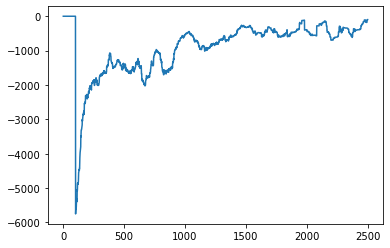

In [8]:
plt.plot(moving_scores[:2500])
print(f'100-episode average score: {moving_scores[-1]}')

100-episode average timesteps: 17.182784556911383


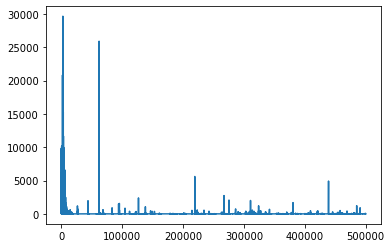

In [9]:
plt.plot(ts)
print(f'100-episode average timesteps: {np.mean(ts[:-100])}')

Illegal moves: 0; Illegal drop-offs/pickups: 0


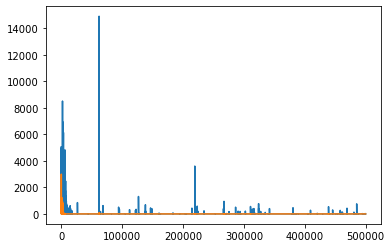

In [10]:
plt.plot(illegal_moves)
plt.plot(illegal_others)
print(f'Illegal moves: {illegal_moves[-1]}; Illegal drop-offs/pickups: {illegal_others[-1]}')

#### From figures above, we can tell:
##### 1. On-policy TD training used up all the eposides, so it's very time-consuming
##### 2. The performance is increasing overall but still quite unstable
##### 3. In the end, the policy is able to give proper guidance.

## Q-learning

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Update the action value $Q(s_t,a_t)$ using the following equation:

$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma max_{a}Q(s_{t+1},a) - Q(s_t,a_t))$

where $max_{a}Q(s_{t+1},a)$ is the highest action value given state $s_{t+1}$. 

This is very similar to SARSA except for the fact that we will always choose the best action value as opposed to epsilon-greedy action selection of SARSA. For this reason, SARSA is called **on-policy** and Q-learning **off-policy**.

Q2

**Implement** 

`off_policy_td_q_learning` method inside `taxi_v3_agent.py` file.

Then run the following code blocks to generate the outputs and plots. Discuss the output results in brief. 

**Are there any significant differences in terms of the results between onpolicy and offpolicy TD Learning based on the results especially in terms of speed? Why?**

In [11]:
env = gym.make('Taxi-v3')

a = TaxiAgent(env, gamma = 0.8, alpha = 1e-1,
        start_epsilon = 1, end_epsilon = 1e-2, epsilon_decay = 0.999)

scores = []
ts = []
illegal_moves = []
illegal_others = []
moving_scores = []
moving_nb = 100
solved_score = 8.5
start_time = datetime.now()

for i in trange(500000):
    #for the record
    score = 0
    t= 0
    illegal_move = 0
    illegal_other = 0
    
    #initiate state
    state = env.reset()
    while True:
        
        #get action
        action = a.select_action(state, a.get_epsilon(i))
        
        #step environment
        next_state, reward, done, info = env.step(action)
        
        #update agent
        a.off_policy_td_q_learning(state, action, reward, next_state)
        
        #records
        score+=reward
        t+=1
        if state==next_state: illegal_move+=1
        if reward==-10: illegal_other+=1
        
        #move to next state
        state = next_state
        
        #end if drop off at destination
        if reward==20: break
            
    #record
    scores.append(score)
    ts.append(t)
    illegal_moves.append(illegal_move)
    illegal_others.append(illegal_other)
    
    if i > moving_nb:
        moving_score = np.mean(scores[i-moving_nb:i])
        moving_scores.append(moving_score)
    else:
        moving_scores.append(0)
        
    #break if solved
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

  1%|█                                                                          | 6903/500000 [00:10<12:38, 650.14it/s]

Solved at Play 6903: 0:00:10.621639 Moving average: 8.53


100-episode average score: 8.53


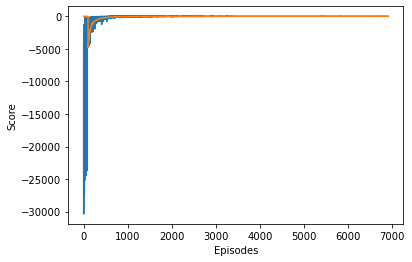

In [12]:
plt.plot(scores)
plt.plot(moving_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
print(f'100-episode average score: {moving_scores[-1]}')

100-episode average timesteps: 43.31804820693709


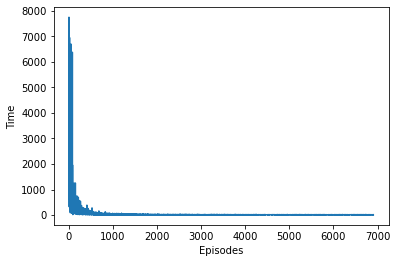

In [13]:
plt.plot(ts)
plt.ylabel('Time')
plt.xlabel('Episodes')
print(f'100-episode average timesteps: {np.mean(ts[:-100])}')

Illegal moves: 0; Illegal drop-offs/pickups: 0


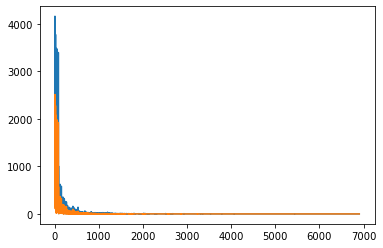

In [14]:
plt.plot(illegal_moves)
plt.plot(illegal_others)
print(f'Illegal moves: {illegal_moves[-1]}; Illegal drop-offs/pickups: {illegal_others[-1]}')

#### Yes, there is a huge difference between two approaches in terms of speed. Off-policy methods have high sample efficiency and lower sample expense. Becasue we do not have to interact with the environment during every update steps.
#### Since during off-policy TD learning, the action is picked using argmax, the whole learning process would be much easier for the agent if enough trajectories are provided. The results in terms of number of timesteps and average scores are better that SARSA. However, it might raise overestimation problem, since we are using the same function for estimation and action selection.

**Q3**

Based on what we have learned, would Monte Carlo be a better method than TD learning for this game? Justify your answer using one or two points of arguments.

#### From my perspective, I would choose TD learning for this game. Here are my reasons:
##### 1. The action space is big compared with other easier task. So if we are using MC, we might need to generate a huge amount of trajectories or say exploration the state and action space for a long time before the agent begins to learn.
##### 2.  From observation, the number of timesteps can be really big, and it will make MC methods less efficient.
##### 2. Compared with driving in real world, we are applying TD learning. In this task, ajust immediately might give better overall performances.